In [1]:
import pandas as pd
import numpy as np
from experiments import get_cysec_dataset, split_training_data, train_model, run_experiments, flatten_experiments_results
random_state=1337

# SET Determinism
from os import environ
environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

# Disable logging 
import logging
def set_global_logging_level(level=logging.ERROR, prefices=[""]):
    import re
    prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })')
    for name in logging.root.manager.loggerDict:
        if re.match(prefix_re, name):
            logging.getLogger(name).setLevel(level)
set_global_logging_level(logging.CRITICAL) # disable INFO and DEBUG logging everywhere

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = get_cysec_dataset('data/dataset_1.json', random_state=random_state)
data[:3]

,tweetId,userId,text,label,createdAt,displayTextRangeStart,getDisplayTextRangeEnd,label_train,label_bin,label_tri,display_text
0,1202047633398759400,285428413,@noopkat @holtbt MOST FUN DAY EVER HAHAHAH but...,1,{'$date': '2019-12-04T02:11:03Z'},17,148,0,0,0,MOST FUN DAY EVER HAHAHAH but seriously love s...
1,1201870222589939700,15180137,Consider giving to these privacy-focused chari...,2,{'$date': '2019-12-03T14:26:05Z'},0,94,1,1,1,Consider giving to these privacy-focused chari...
2,1207281430637826000,272760181,@zackwhittaker Very brave of your both to shar...,1,{'$date': '2019-12-18T12:48:17Z'},15,85,0,0,0,Very brave of your both to share your story. I...


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_hist(data, title=""):
    sns.histplot(data).set_title(title)
    plt.xticks(np.unique(data))
    plt.show()

def plot_four_hists(data1, data2, data3, data4, title1="", title2="", title3="", title4=""):
    fig, ax =plt.subplots(1,4, figsize=(17,4))
    sns.histplot(data1, ax = ax[0])
    sns.histplot(data2, ax = ax[1])
    sns.histplot(data3, ax = ax[2])
    sns.histplot(data4, ax = ax[3])
    ax[0].legend(labels=[], title=title1)
    ax[1].legend(labels=[], title=title2)
    ax[2].legend(labels=[], title=title3)
    ax[3].legend(labels=[], title=title4)
    ax[0].set_xticks(np.unique(data1))
    ax[1].set_xticks(np.unique(data2))
    ax[2].set_xticks(np.unique(data3))
    ax[3].set_xticks(np.unique(data4))
    fig.tight_layout()
    fig.show()
    
def print_plot(results, title="Experiments"):
    fig, ax =plt.subplots(1,2, figsize=(18,7))
    sns.lineplot(data=results, hue='algorithm', x = "trained_samples" , y = "_accuracy", ci='sd', linewidth=1, ax = ax[0])
#     sns.lineplot(data=results[results.algorithm=='res_rand'], x = "trained_samples" ,y = "_accuracy", ci='sd',  color='orange', linewidth=1, ax = ax[0])
#     sns.lineplot(data=results[results.algorithm=='res_sbert'], x = "trained_samples" ,y = "_accuracy", ci='sd',  color='blue', linewidth=1, ax = ax[0])
#     sns.lineplot(data=results[results.algorithm=='res_bt'], x = "trained_samples" ,y = "_accuracy",  color='green', linewidth=1, ax = ax[0])
    sns.lineplot(data=results, hue='algorithm', x = "trained_samples" , y = "_f1", ci='sd', linewidth=1, ax = ax[1])
#     sns.lineplot(data=results[results.algorithm=='res_rand'], x = "trained_samples" ,y = "_f1",  color='orange', linewidth=1, ax = ax[1])
#     sns.lineplot(data=results[results.algorithm=='res_sbert'], x = "trained_samples" ,y = "_f1",  color='blue', linewidth=1, ax = ax[1])
#     sns.lineplot(data=results[results.algorithm=='res_bt'], x = "trained_samples" ,y = "_f1",  color='green', linewidth=1, ax = ax[1])
    
    ax[0].legend(labels=["Random", "SBERT", "BERTopic"], title = "Accuracy " + title)
    ax[1].legend(labels=["Random", "SBERT", "BERTopic"], title = "F1 " + title)
    fig.show()
# plot_four_hists(data[label_col], y_train, y_val, y_test, title1="Dataset label distribution", title2="Train label distribution", title3="Validation label distribution", title4="Test label distribution")

In [4]:
X_train, y_train, X_test, y_test = split_training_data(data['display_text'], data['label_train'], n_splits=1, random_state=random_state, test_split_ratio=0.4, ) 
X_test, y_test, X_val, y_val = split_training_data(X_test, y_test, n_splits=1, test_split_ratio=0.4, random_state=random_state) 
metrics1, trainer1, model1, tokenizer1 = train_model(X_train, y_train, X_val, y_val, X_test, y_test, random_state=random_state)
metrics2, trainer2, model2, tokenizer2 = train_model(X_train, y_train, X_val, y_val, X_test, y_test, random_state=random_state)
metrics1, metrics2

Some weights of the model checkpoint at ./distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'clas

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.485839,0.812261,0.754170,0.812261,0.773580
2,No log,0.387103,0.858238,0.836809,0.858238,0.835958
3,No log,0.348861,0.865900,0.836768,0.865900,0.849584


***** Running Evaluation *****
  Num examples = 1044
  Batch size = 128
***** Running Evaluation *****
  Num examples = 1044
  Batch size = 128
***** Running Evaluation *****
  Num examples = 1044
  Batch size = 128


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 1566
  Batch size = 128


({'_loss': 0.33466213941574097,
  '_accuracy': 0.8754789272030651,
  '_precision': 0.8844024957501483,
  '_recall': 0.8754789272030651,
  '_f1': 0.863220043474942,
  '_runtime': 1.8244,
  '_samples_per_second': 858.374,
  '_steps_per_second': 7.126,
  'epoch': 3.0},
 {'_loss': 0.33466213941574097,
  '_accuracy': 0.8754789272030651,
  '_precision': 0.8844024957501483,
  '_recall': 0.8754789272030651,
  '_f1': 0.863220043474942,
  '_runtime': 1.7828,
  '_samples_per_second': 878.395,
  '_steps_per_second': 7.292,
  'epoch': 3.0})

## Experiment 1

In [5]:
ex = run_experiments(data, train_col='display_text', label_col='label_train', n_splits=5, sample_size=100, ml_batch_size=50, ml_epochs=15, random_states=[0, 42, 1337, 489, 555], stop_at=1500)
ex

Duration: 10:56:35.290700 Duration: 0:00:39.722780 AL:0:00:09.284112 ML:0:00:30.438592


{'res_rand': [[       _loss  _accuracy  _precision   _recall       _f1  _runtime  \
   0   0.633236   0.786207    0.618121  0.786207  0.692105    1.4428   
   1   0.633880   0.807663    0.759945  0.807663  0.760919    1.4261   
   2   0.616003   0.803831    0.744552  0.803831  0.767456    1.4453   
   3   0.477202   0.844444    0.824375  0.844444  0.828380    1.4411   
   4   0.475347   0.849808    0.856480  0.849808  0.838322    1.4402   
   5   0.521672   0.851341    0.852474  0.851341  0.841280    1.4300   
   6   0.565140   0.845977    0.859021  0.845977  0.851043    1.4386   
   7   0.556972   0.869732    0.856553  0.869732  0.858237    1.4270   
   8   0.504492   0.860536    0.865081  0.860536  0.861867    1.4259   
   9   0.591641   0.868966    0.865875  0.868966  0.861271    1.4283   
   10  0.524494   0.864368    0.872511  0.864368  0.866589    1.4365   
   11  0.470023   0.865134    0.860532  0.865134  0.860016    1.4307   
   12  0.512982   0.875862    0.869219  0.875862  0.

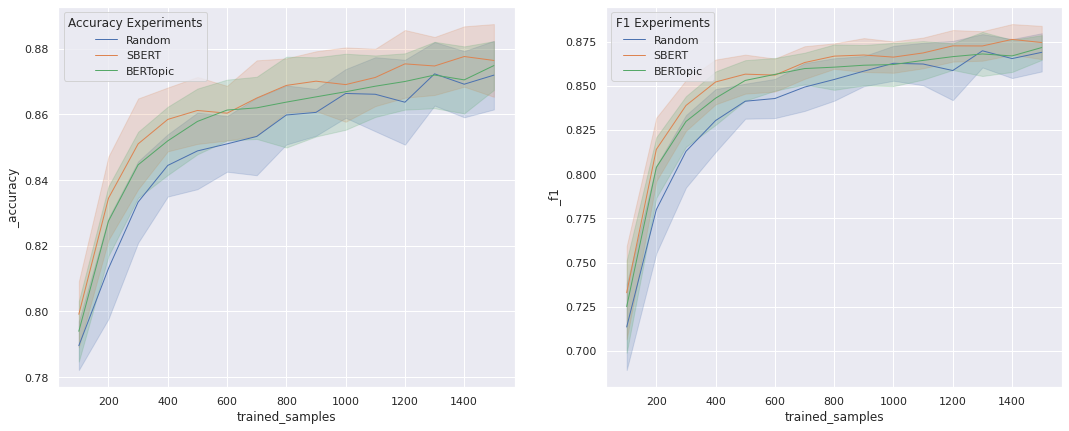

In [7]:
df = pd.DataFrame(flatten_experiments_results(ex))
print_plot(df)

## Experiment 2

In [8]:
ex_800 = run_experiments(data, train_col='display_text', label_col='label_train', n_splits=5, sample_size=100, ml_batch_size=50, ml_epochs=15, random_states=[0, 42, 1337, 489, 555], stop_at=800)

Duration: 5:58:44.311797 Duration: 0:00:42.139825 AL:0:00:11.795934 ML:0:00:30.343800


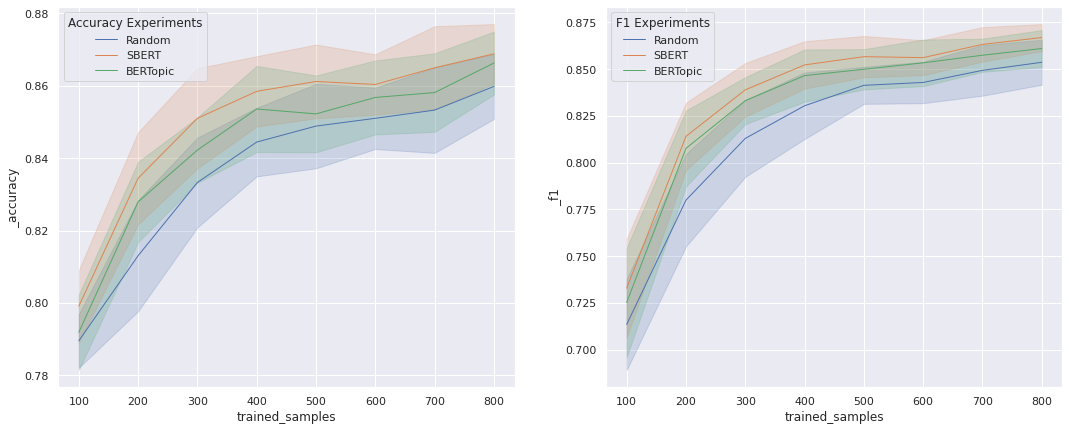

In [9]:
print_plot(pd.DataFrame(flatten_experiments_results(ex_800)))

## Experiment Full

In [10]:
ex_full = run_experiments(data, train_col='display_text', label_col='label_train', n_splits=5, sample_size=100, ml_batch_size=50, ml_epochs=15, random_states=[0, 42, 1337, 489, 555])

Exception in thread Exception in threading.excepthook:Exception ignored in thread started byException ignored in sys.unraisablehook

KeyboardInterrupt: 

In [11]:
print_plot(pd.DataFrame(flatten_experiments_results(ex_full)))

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.

Exception in thread Exception in threading.excepthook:Exception ignored in thread started byException ignored in sys.unraisablehook

NameError: name 'ex_full' is not defined

## Experiments trinary

In [12]:
ex_800_tri = run_experiments(data, train_col='display_text', label_col='label_tri', n_splits=5, sample_size=100, ml_batch_size=50, ml_epochs=15, random_states=[0, 42, 1337, 489, 555], stop_at=800)

OSError: [Errno 24] Too many open files: '/home/kstrassheim/.huggingface/token'

In [ ]:
print_plot(pd.DataFrame(flatten_experiments_results(ex_800_tri)))

## Experiments binary

In [ ]:
ex_800_bin = run_experiments(data, train_col='display_text', label_col='label_bin', n_splits=5, sample_size=100, ml_batch_size=50, ml_epochs=15, random_states=[0, 42, 1337, 489, 555], stop_at=800)

In [ ]:
print_plot(pd.DataFrame(flatten_experiments_results(ex_800_bi)))